In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
train_path = "./UCI HAR Dataset/train"
test_path = "./UCI HAR Dataset/test" #not using, mentioned just for reference

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(2)

/Users/aryan/Desktop/Academics /Semester 4/Mathematical Foundations for AI/coding1_assignment_cs303/venv/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
#Load all the accelerometer body acceleration data
body_acc_x_windowed = pd.read_csv(os.path.join(train_path,"Inertial Signals","body_acc_x_train.txt"),sep='\s+',header=None)
body_acc_y_windowed = pd.read_csv(os.path.join(train_path,"Inertial Signals","body_acc_y_train.txt"),sep='\s+',header=None)
body_acc_z_windowed = pd.read_csv(os.path.join(train_path,"Inertial Signals","body_acc_z_train.txt"),sep='\s+',header=None)

body_acc_x_windowed_np = body_acc_x_windowed.to_numpy()
body_acc_y_windowed_np = body_acc_y_windowed.to_numpy()
body_acc_z_windowed_np = body_acc_z_windowed.to_numpy()

In [5]:
n = 500 #number of time series vectors
#reduced for faster computation
#### SHAPE OF THE DATA - Written this way for identification######

'''Let us take 1 to 500=> this has all activities'''

'Let us take 1 to 500=> this has all activities'

In [8]:
body_acc_x_windowed_np= body_acc_x_windowed_np[:500]
body_acc_y_windowed_np= body_acc_y_windowed_np[:500]
body_acc_z_windowed_np= body_acc_z_windowed_np[:500]
body_acc_x_windowed_np.shape

(500, 128)

In [10]:
file_path = "UCI HAR Dataset/train/y_train.txt"

y_train = np.loadtxt(file_path, dtype=int)
y_train_need = y_train[:500]

$$ d(i, j) = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2 + (z_i - z_j)^2} $$

$$d = \sqrt{\sum_{k=1}^{3} (v_{i,k} - v_{j,k})^2}$$

In [ ]:
euc_distance_matrix = np.zeros((n, n))

#Euclidean distance for all three axes combined
def compute_combined_euclidean(i, j):
    combined_vector_i = np.stack(
        (body_acc_x_windowed_np[i], body_acc_y_windowed_np[i], body_acc_z_windowed_np[i]), axis=-1
    )
    combined_vector_j = np.stack(
        (body_acc_x_windowed_np[j], body_acc_y_windowed_np[j], body_acc_z_windowed_np[j]), axis=-1
    )
    return np.sqrt(np.sum((combined_vector_i - combined_vector_j) ** 2))

index_pairs = [(i, j) for i in range(n) for j in range(n)]
with tqdm_joblib(tqdm(desc="Computing Combined Euclidean Distances", total=len(index_pairs))):
    results = Parallel(n_jobs=-1)(delayed(compute_combined_euclidean)(i, j) for i, j in index_pairs)

for idx, (i, j) in enumerate(index_pairs):
    euc_distance_matrix[i, j] = results[idx]

100%|██████████| 250000/250000 [00:02<00:00, 124468.10it/s]250000 [00:00<?, ?it/s]


In [14]:
df = pd.DataFrame(euc_distance_matrix, 
                    columns=[f"Vec {i+1}" for i in range(n)], 
                    index=[f"Vec {i+1}" for i in range(n)])
df

,Vec 1,Vec 2,Vec 3,Vec 4,Vec 5,Vec 6,Vec 7,Vec 8,Vec 9,Vec 10,...,Vec 491,Vec 492,Vec 493,Vec 494,Vec 495,Vec 496,Vec 497,Vec 498,Vec 499,Vec 500
Vec 1,0.000000,0.309923,0.276805,0.220292,0.267147,0.264037,0.264085,0.208832,0.291609,0.260313,...,2.898153,2.747357,2.953788,3.073144,3.028675,3.062171,3.073169,3.630442,3.594339,3.515375
Vec 2,0.309923,0.000000,0.207684,0.163196,0.127806,0.158564,0.211023,0.214910,0.129782,0.175022,...,2.857902,2.692315,2.976093,3.034237,2.994487,3.068784,3.086535,3.641575,3.510182,3.494974
Vec 3,0.276805,0.207684,0.000000,0.166529,0.165106,0.155458,0.124620,0.184276,0.193338,0.180723,...,2.874594,2.689068,2.963663,3.049383,3.003412,3.068756,3.080061,3.673050,3.544353,3.494732
Vec 4,0.220292,0.163196,0.166529,0.000000,0.125410,0.156508,0.170069,0.126316,0.145365,0.171353,...,2.874665,2.709214,2.963089,3.046656,2.997867,3.069136,3.085831,3.637078,3.540204,3.496726
Vec 5,0.267147,0.127806,0.165106,0.125410,0.000000,0.111165,0.164991,0.175194,0.112660,0.138172,...,2.864209,2.698091,2.975018,3.036968,2.991242,3.054611,3.077778,3.645499,3.532915,3.477816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vec 496,3.062171,3.068784,3.068756,3.069136,3.054611,3.055026,3.048593,3.062893,3.049979,3.059441,...,3.191335,3.353987,5.035810,5.140858,4.063077,0.000000,4.437812,4.883478,5.120215,5.001976
Vec 497,3.073169,3.086535,3.080061,3.085831,3.077778,3.073898,3.064371,3.091014,3.069841,3.085134,...,4.936826,3.643421,3.772487,4.703217,5.152465,4.437812,0.000000,4.888632,4.914743,5.302178
Vec 498,3.630442,3.641575,3.673050,3.637078,3.645499,3.664553,3.682623,3.630354,3.638854,3.658219,...,4.575476,4.838868,4.636191,3.885347,4.237461,4.883478,4.888632,0.000000,3.536809,3.543817
Vec 499,3.594339,3.510182,3.544353,3.540204,3.532915,3.538881,3.544795,3.556007,3.530713,3.541638,...,4.596447,4.925625,4.318445,3.732696,3.814464,5.120215,4.914743,3.536809,0.000000,3.703254


In [15]:
from fastdtw import fastdtw

dtw_distance_matrix = np.zeros((n, n))

#Function to compute 3D DTW distance
def compute_combined_dtw(i, j):
    combined_vector_i = np.stack(
        (body_acc_x_windowed_np[i], body_acc_y_windowed_np[i], body_acc_z_windowed_np[i]), axis=-1
    )
    combined_vector_j = np.stack(
        (body_acc_x_windowed_np[j], body_acc_y_windowed_np[j], body_acc_z_windowed_np[j]), axis=-1
    )
    distance, _ = fastdtw(combined_vector_i, combined_vector_j, dist=euclidean)
    return distance

index_pairs = [(i, j) for i in range(n) for j in range(n)]
with tqdm_joblib(tqdm(desc="Computing Combined DTW Distances", total=len(index_pairs))):
    results = Parallel(n_jobs=-1)(delayed(compute_combined_dtw)(i, j) for i, j in index_pairs)

for idx, (i, j) in enumerate(index_pairs):
    dtw_distance_matrix[i, j] = results[idx]

#Convert the DTW distance matrix to a DataFrame for better visualization
dtw_df = pd.DataFrame(dtw_distance_matrix, 
                      columns=[f"Vec {i+1}" for i in range(n)], 
                      index=[f"Vec {i+1}" for i in range(n)])
dtw_df

100%|██████████| 250000/250000 [03:24<00:00, 1223.49it/s]00 [00:00<?, ?it/s]


,Vec 1,Vec 2,Vec 3,Vec 4,Vec 5,Vec 6,Vec 7,Vec 8,Vec 9,Vec 10,...,Vec 491,Vec 492,Vec 493,Vec 494,Vec 495,Vec 496,Vec 497,Vec 498,Vec 499,Vec 500
Vec 1,0.000000,1.997852,2.266590,1.792746,2.065788,2.448903,2.456767,1.850808,2.218926,2.446943,...,29.885376,28.738277,30.437314,31.639652,31.104314,31.360699,32.095626,37.731203,36.657294,35.356273
Vec 2,1.997852,0.000000,1.050210,1.387636,0.968063,1.323224,1.610651,1.934330,1.149704,1.649911,...,29.482875,28.058271,30.666041,31.049113,30.503905,31.356848,32.400678,37.858582,35.580592,34.995225
Vec 3,2.266590,1.050210,0.000000,1.282381,1.529591,1.371355,1.054220,1.336921,1.387095,1.620700,...,29.660342,28.144993,30.432947,31.280464,30.601872,31.371978,32.248994,38.288414,35.996387,34.978748
Vec 4,1.792746,1.387636,1.282381,0.000000,0.833986,1.488139,1.390232,1.036608,1.160255,1.480145,...,29.631986,28.334328,30.513240,31.239807,30.656727,31.390355,32.379163,37.897174,36.025337,35.090692
Vec 5,2.065788,0.968063,1.529591,0.833986,0.000000,0.697993,1.479042,1.232226,1.012571,1.245084,...,29.492263,28.165024,30.644353,31.059636,30.473198,31.225454,32.238945,37.904444,35.845692,34.818848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vec 496,31.360699,31.356848,31.371978,31.390355,31.225454,31.196912,31.201702,31.318662,31.207476,31.229381,...,29.459514,26.403810,27.065364,18.015752,20.873018,0.000000,19.906202,21.907524,24.334158,23.533992
Vec 497,32.095626,32.400678,32.248994,32.379163,32.238945,32.192514,32.116675,32.443545,32.179905,32.348588,...,23.584343,31.466171,32.057452,26.473726,23.883263,19.906202,0.000000,40.068336,30.073901,31.483013
Vec 498,37.731203,37.858582,38.288414,37.897174,37.904444,38.107904,38.375405,37.818563,37.860010,37.963403,...,31.244068,34.038001,28.473011,21.278612,23.435789,21.907524,40.068336,0.000000,24.641432,25.445460
Vec 499,36.657294,35.580592,35.996387,36.025337,35.845692,35.904301,36.096663,36.200311,35.892036,35.900349,...,33.714957,26.839535,25.441471,19.735157,20.304061,24.334158,30.073901,24.641432,0.000000,24.722088


In [16]:
inverse_euc_sim_matrix = 1 / (1 + euc_distance_matrix)
inverse_dtw_sim_matrix = 1 / (1 + dtw_distance_matrix)

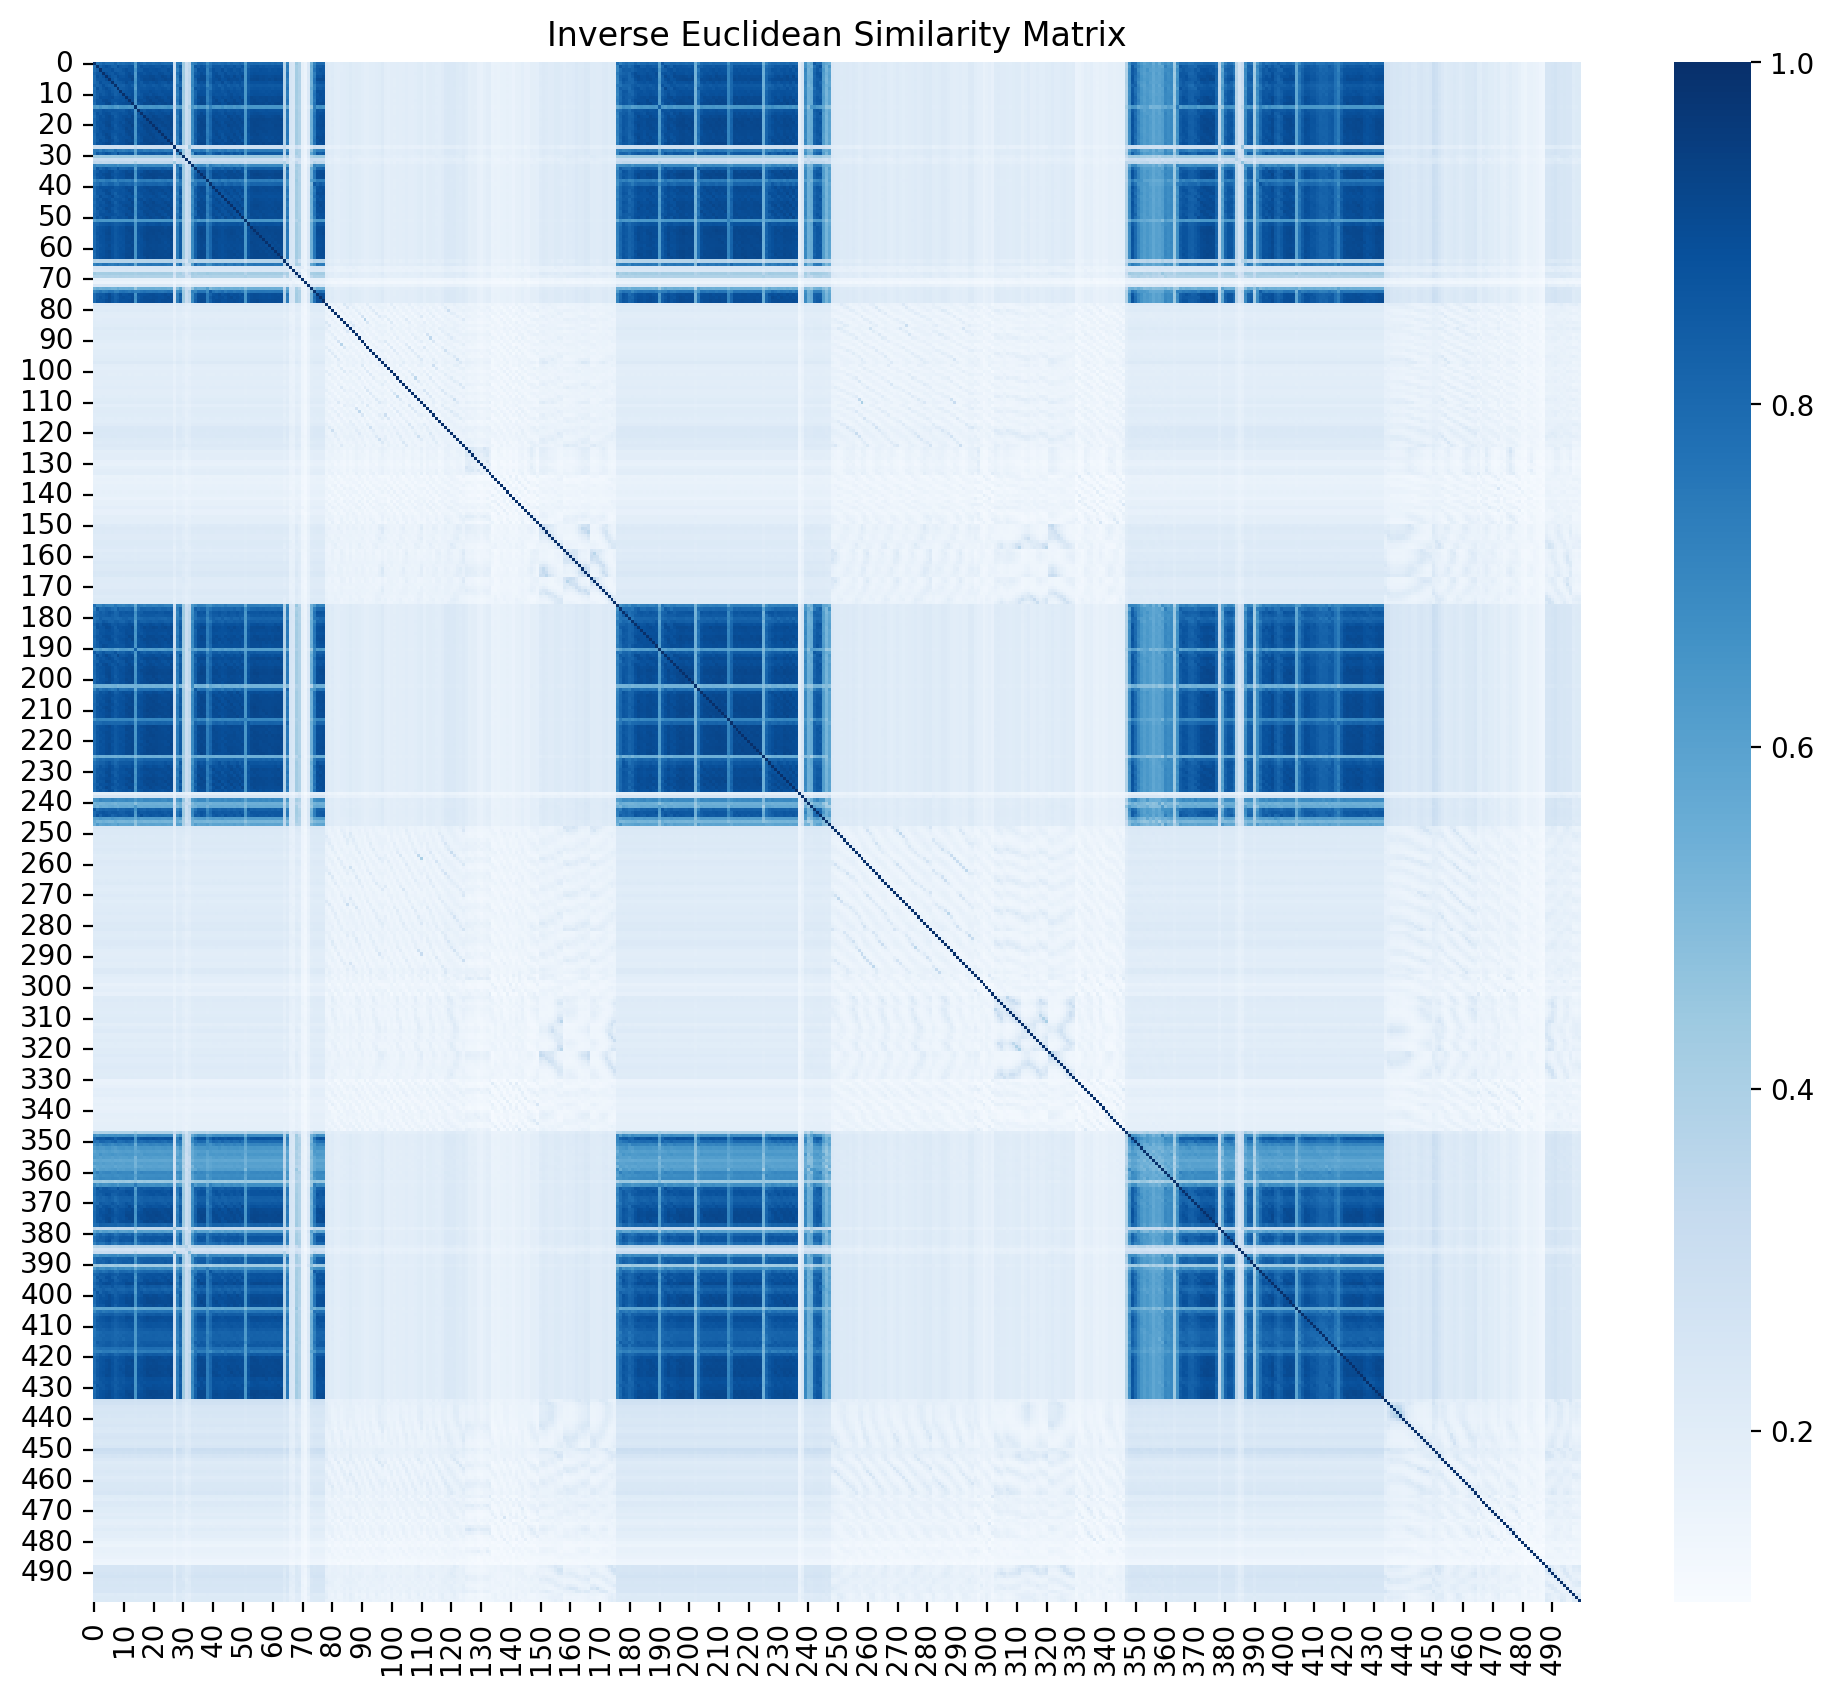

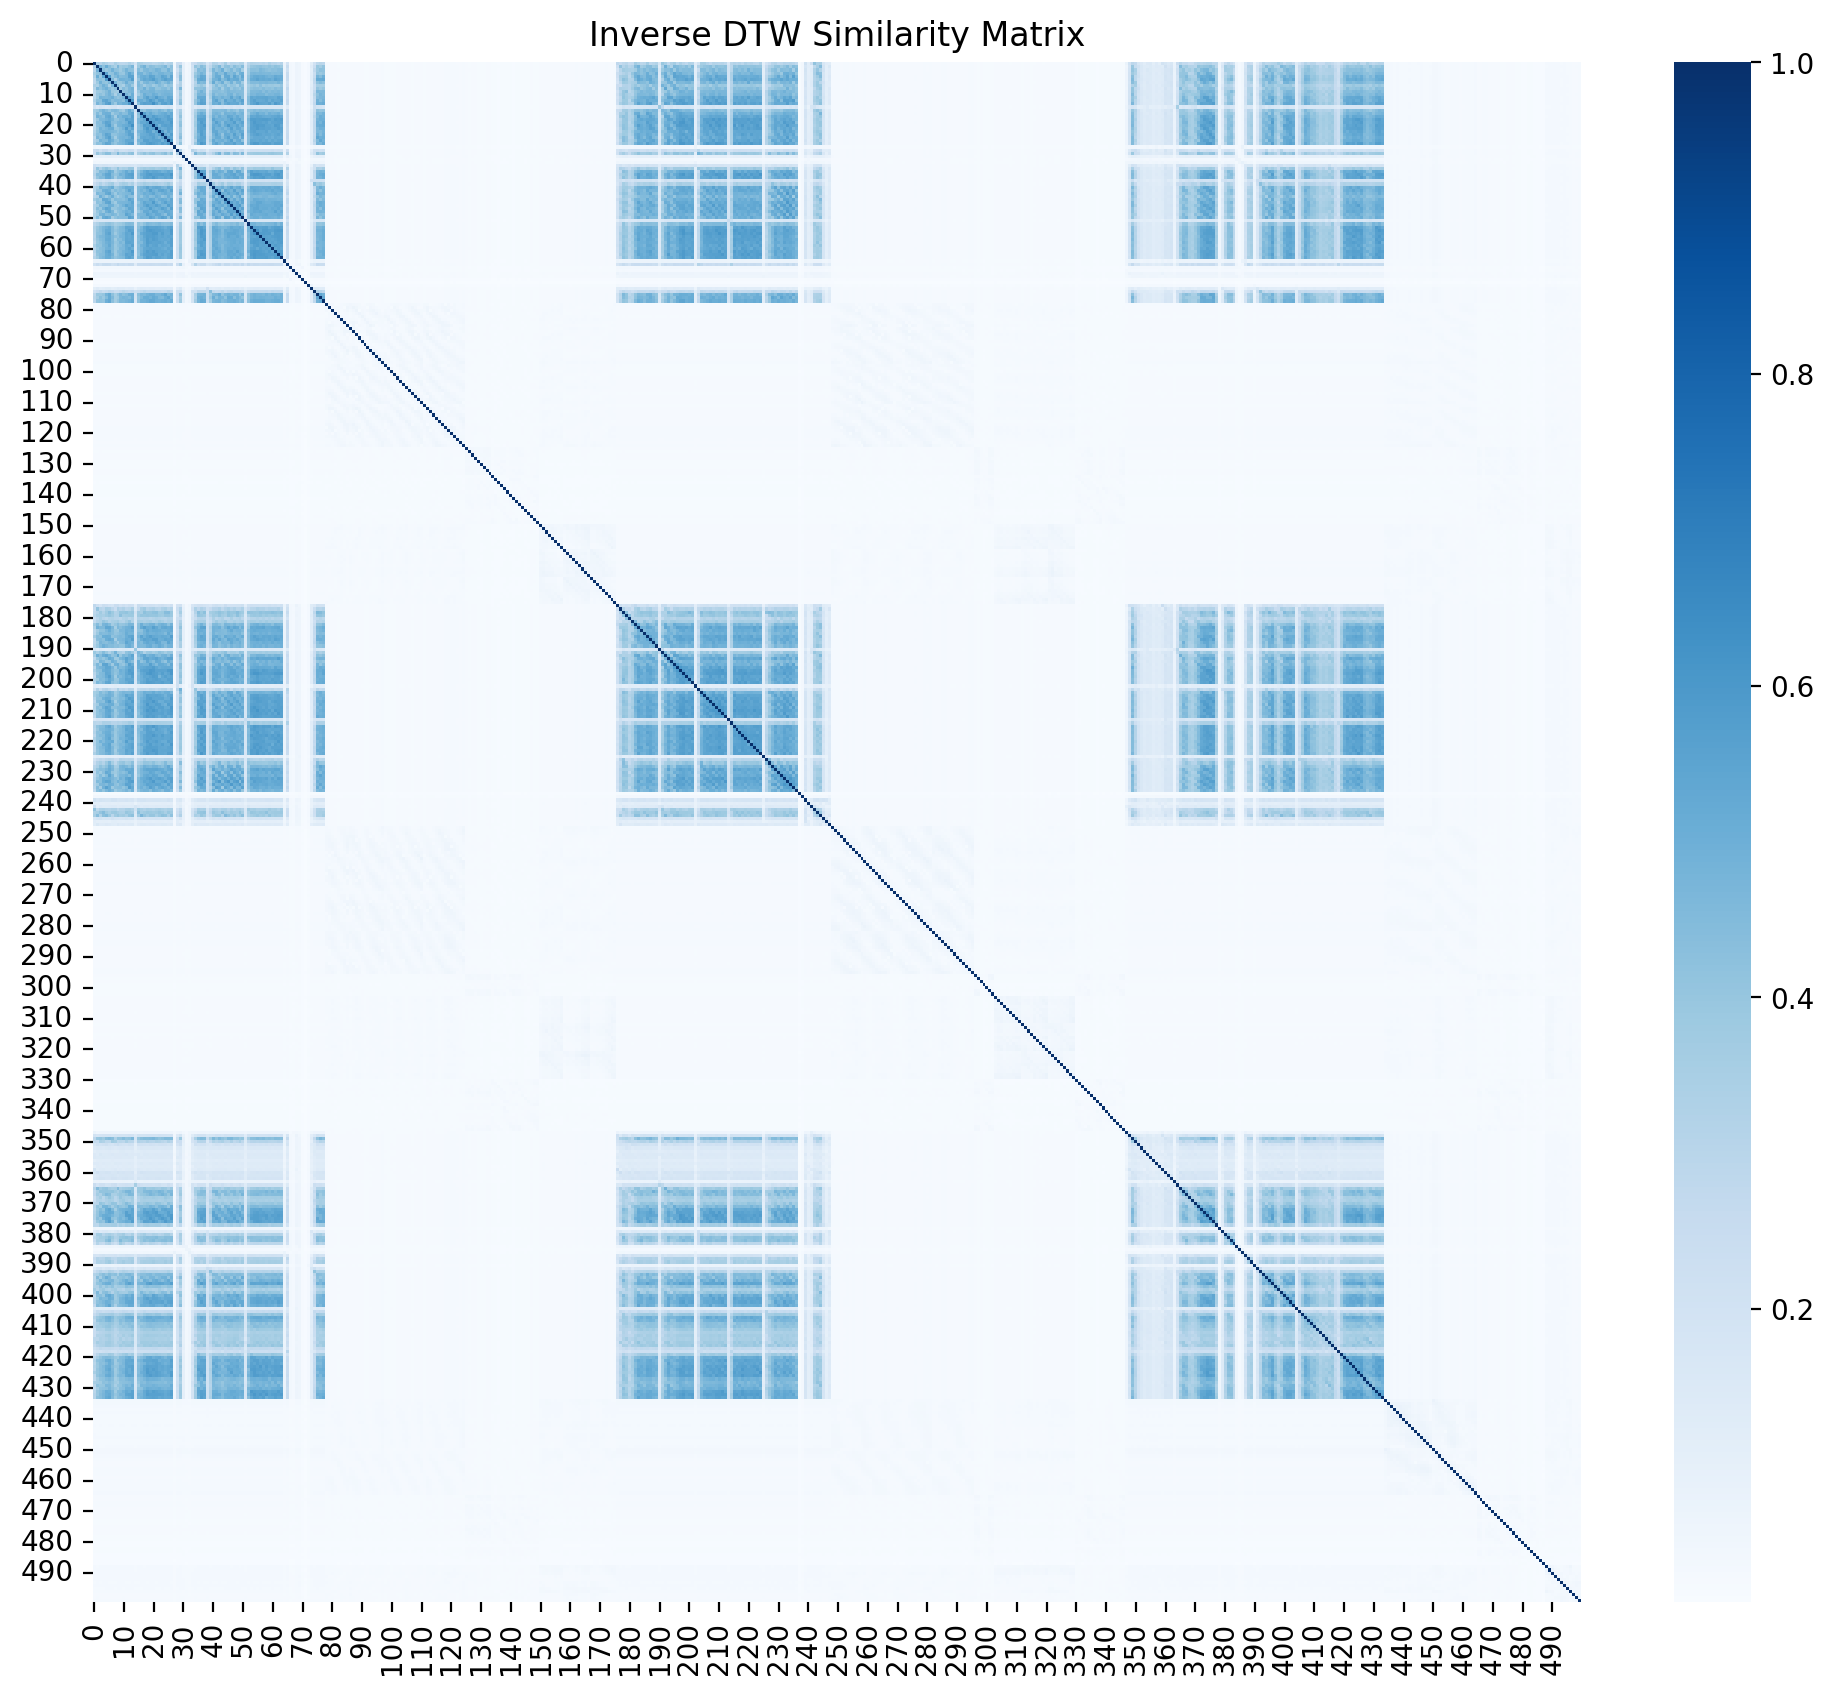

In [21]:
plt.figure(figsize=(12, 10))
plt.title("Inverse Euclidean Similarity Matrix")
sns.heatmap(inverse_euc_sim_matrix, cmap="Blues")
plt.show()

plt.figure(figsize=(12, 10))
plt.title("Inverse DTW Similarity Matrix")
sns.heatmap(inverse_dtw_sim_matrix, cmap="Blues")
plt.show()

In [23]:
sigma = np.median(dtw_distance_matrix[dtw_distance_matrix > 0])  
diffusion_kernel = np.exp(-dtw_distance_matrix ** 2 / (2 * sigma ** 2))

degree_matrix = np.diag(np.sum(diffusion_kernel, axis=1))
D_inv_sqrt = np.diag(1 / np.sqrt(degree_matrix.diagonal()))
L = D_inv_sqrt @ diffusion_kernel @ D_inv_sqrt 

In [26]:
L.shape

(500, 500)

In [27]:
from numpy import linalg as lg

eigvals, eigvecs = lg.eigh(L)

#ascending to descending 
idx = np.argsort(eigvals)[::-1]  
eigvals = eigvals[idx]         
eigvecs = eigvecs[:, idx]  

In [28]:
eigvecs.shape

(500, 500)

In [29]:
Lrw=np.diag(1 / degree_matrix.diagonal()) @ eigvecs

In [30]:
k = 3 #this is the embedding dimension 
diffusion_coords = Lrw[:, 1:k+1] @ np.diag(eigvals[1:k+1].transpose()) 

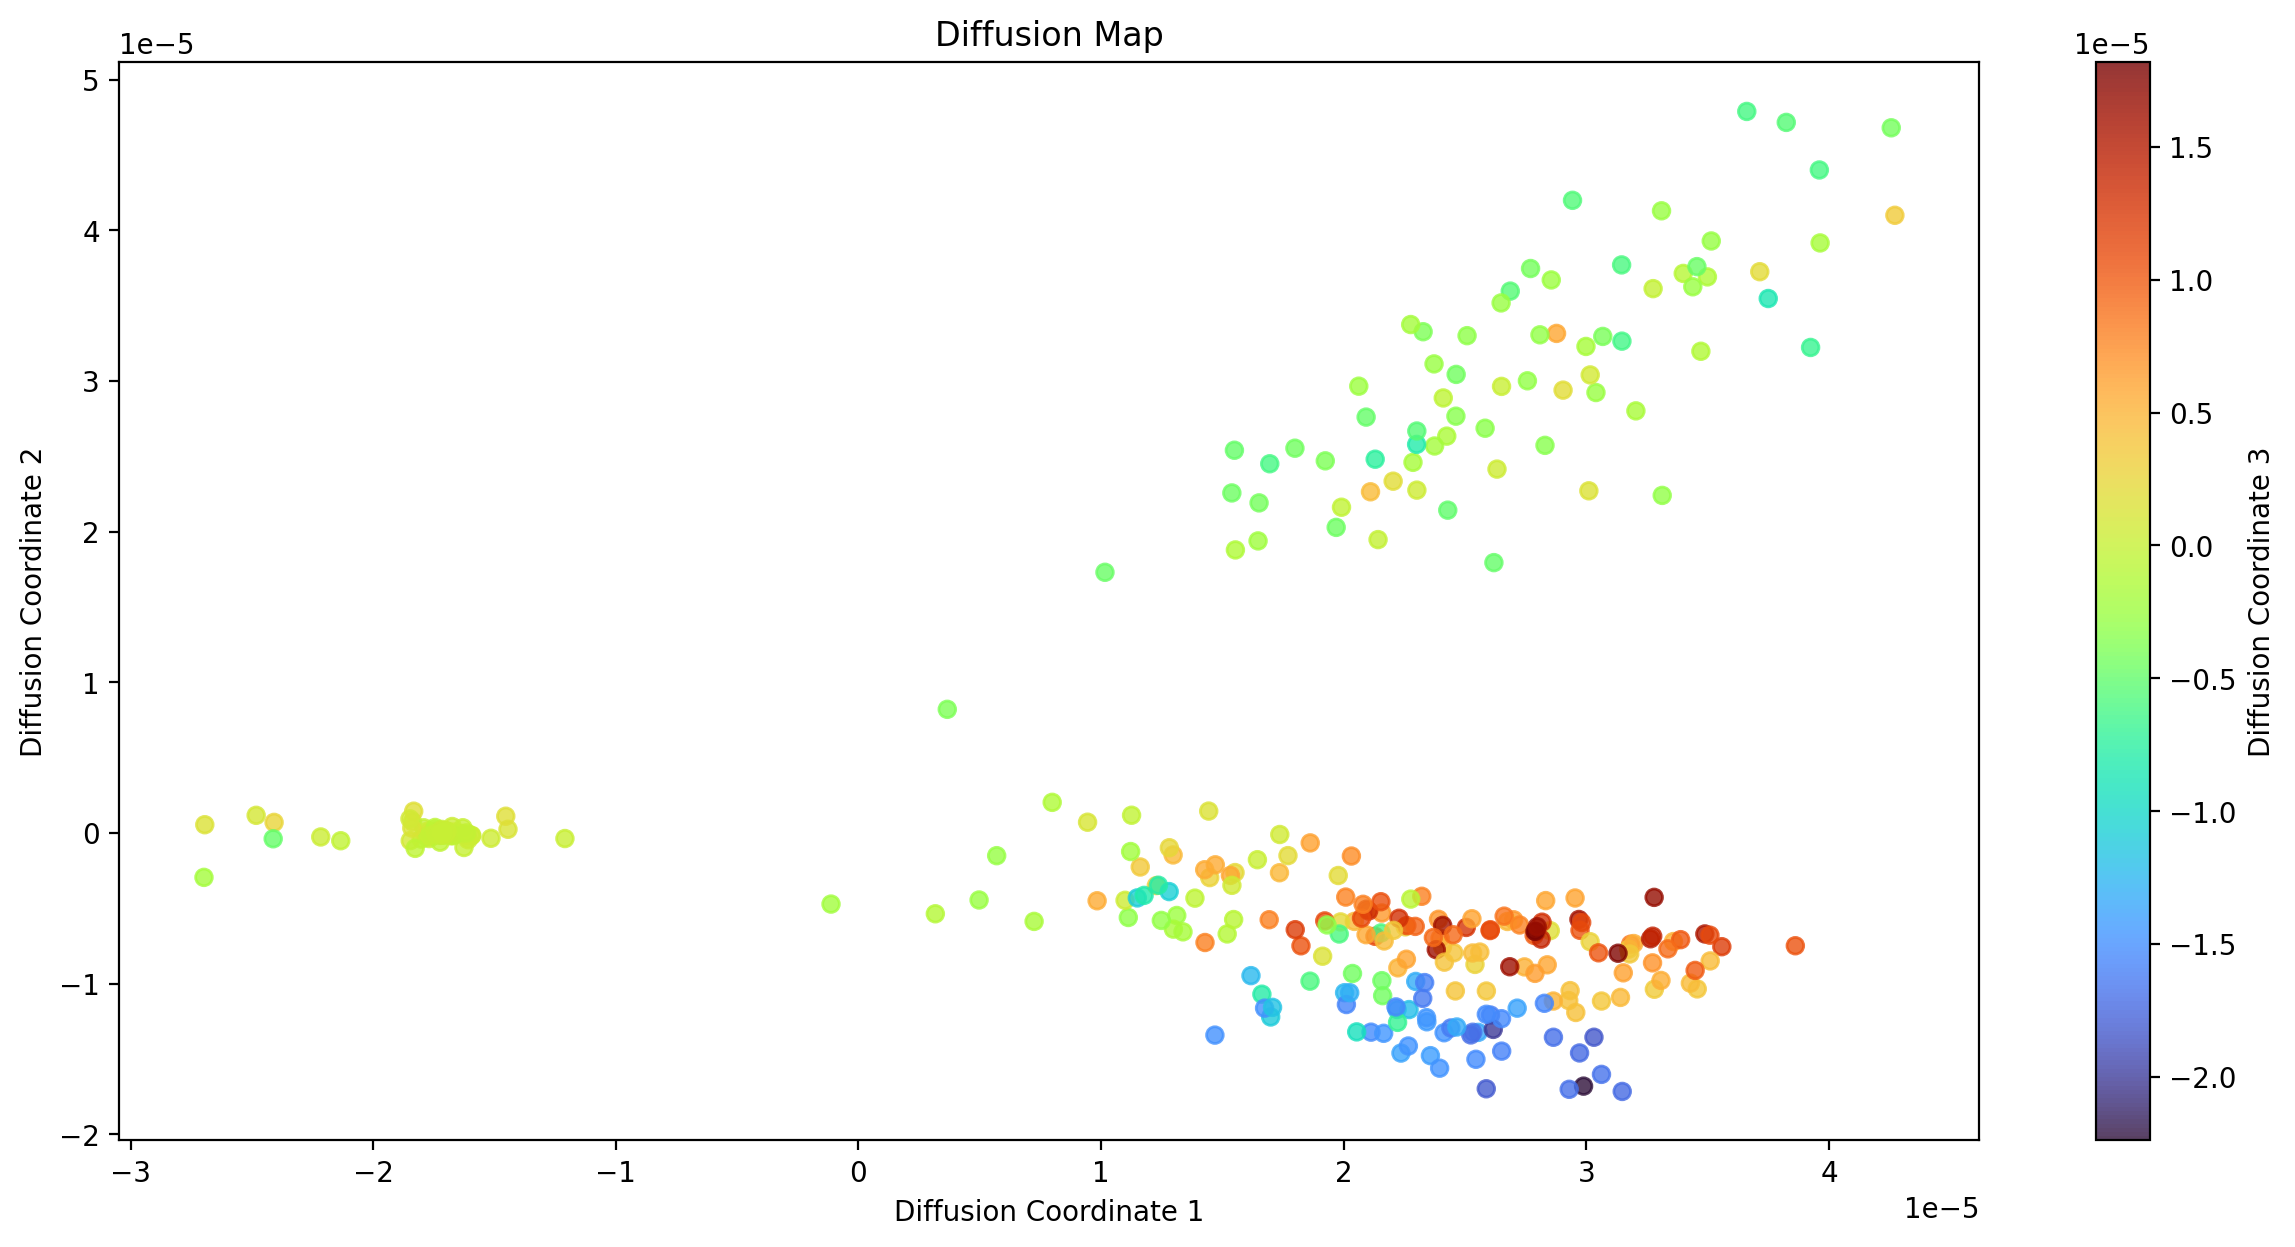

In [38]:
plt.figure(figsize=(15, 7))
plt.scatter(diffusion_coords[:, 0], diffusion_coords[:, 1], c=diffusion_coords[:, 2], cmap='turbo', alpha=0.8)
plt.colorbar(label="Diffusion Coordinate 3")
plt.xlabel("Diffusion Coordinate 1")
plt.ylabel("Diffusion Coordinate 2")
plt.title("Diffusion Map")
plt.show()

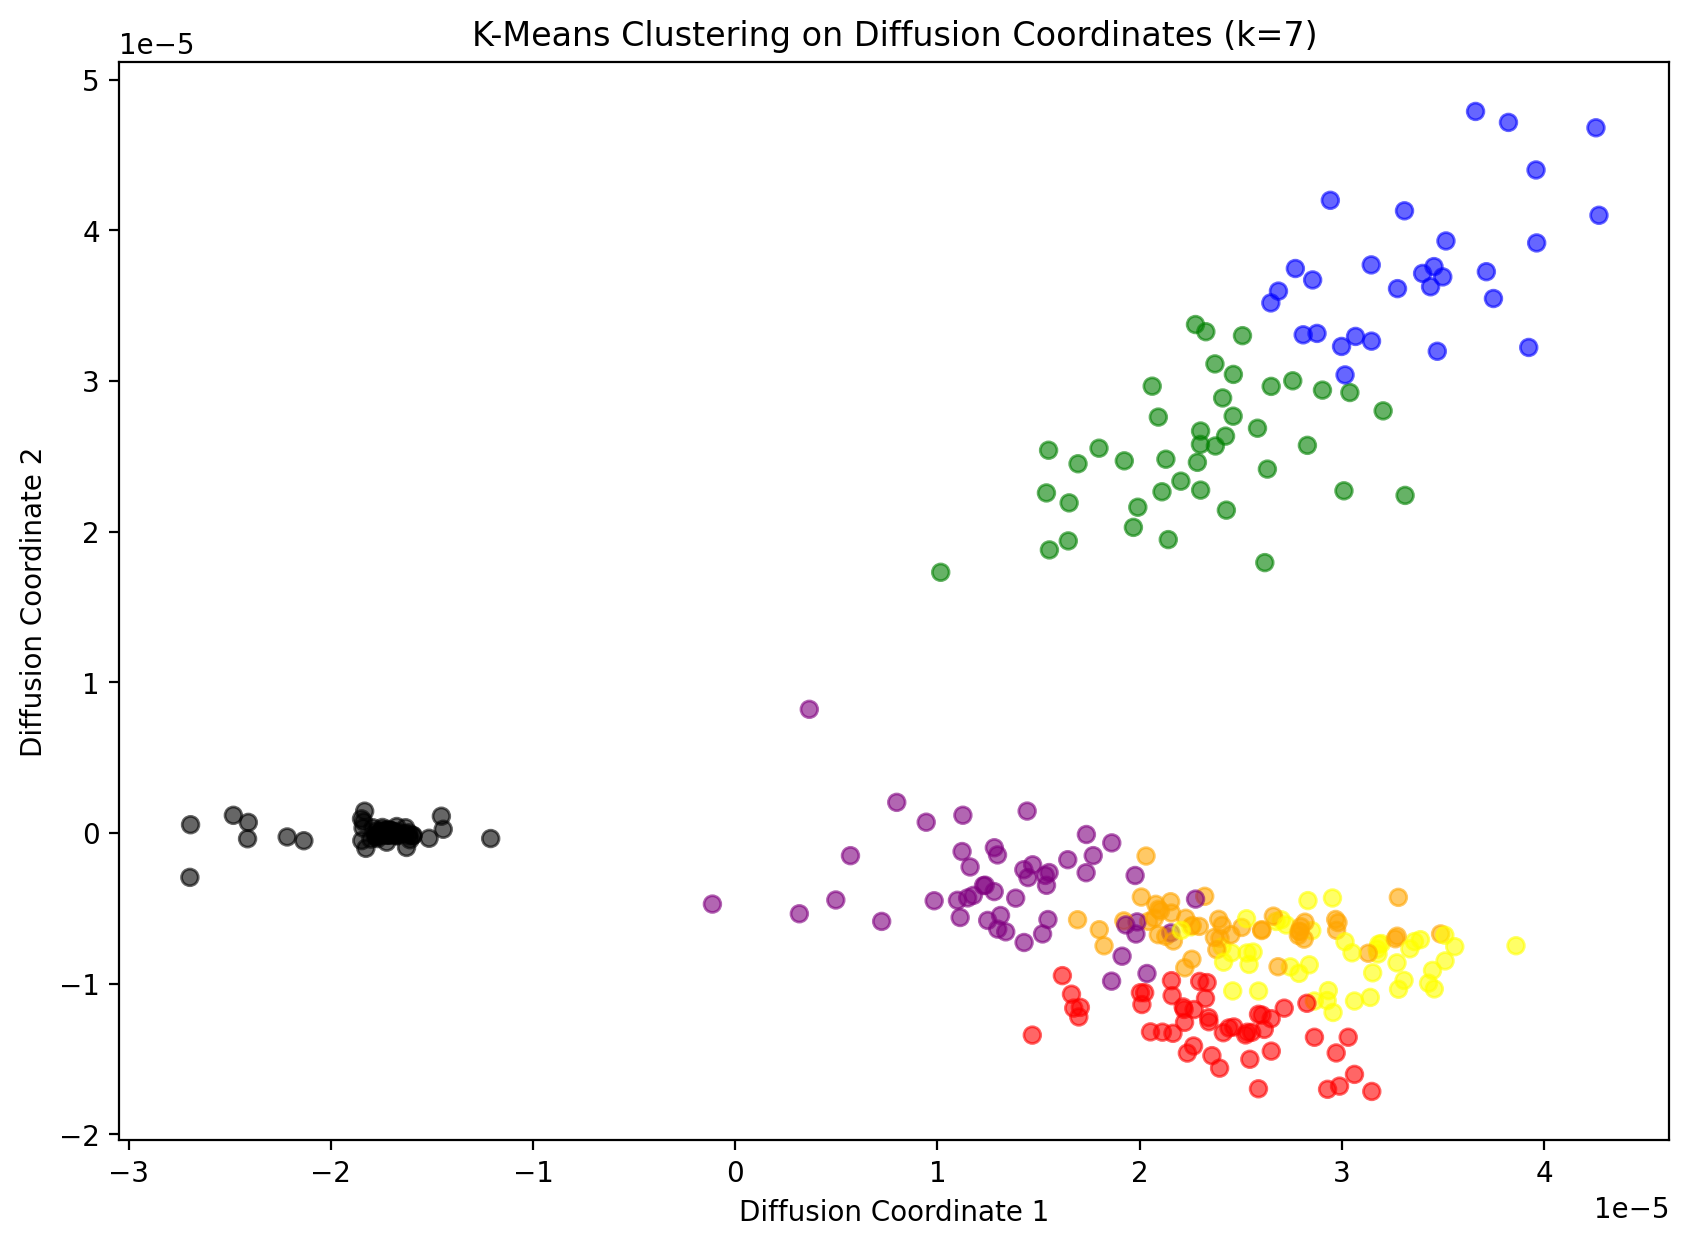

In [ ]:
k_given = 7

cluster_colors = ["black", "yellow", "blue", "red", "green", "purple", "orange"]

kmeans = KMeans(n_clusters=k_given, random_state=2).fit(diffusion_coords)

labels = kmeans.labels_

plt.figure(figsize=(10, 7))
plt.scatter(diffusion_coords[:, 0], diffusion_coords[:, 1], 
            c=[cluster_colors[label] for label in labels], alpha=0.6)
plt.xlabel("Diffusion Coordinate 1")
plt.ylabel("Diffusion Coordinate 2")
plt.title(f"K-Means Clustering on Diffusion Coordinates (k={k_given})")
plt.show()

In [39]:
ari = adjusted_rand_score(y_train_need, labels)

silhouette = silhouette_score(diffusion_coords[:, :2], labels)

print(f"ARI Score = {ari:.4f}")
print(f"Silhouette Score = {silhouette:.4f}")

ARI Score = 0.3926
Silhouette Score = 0.6223


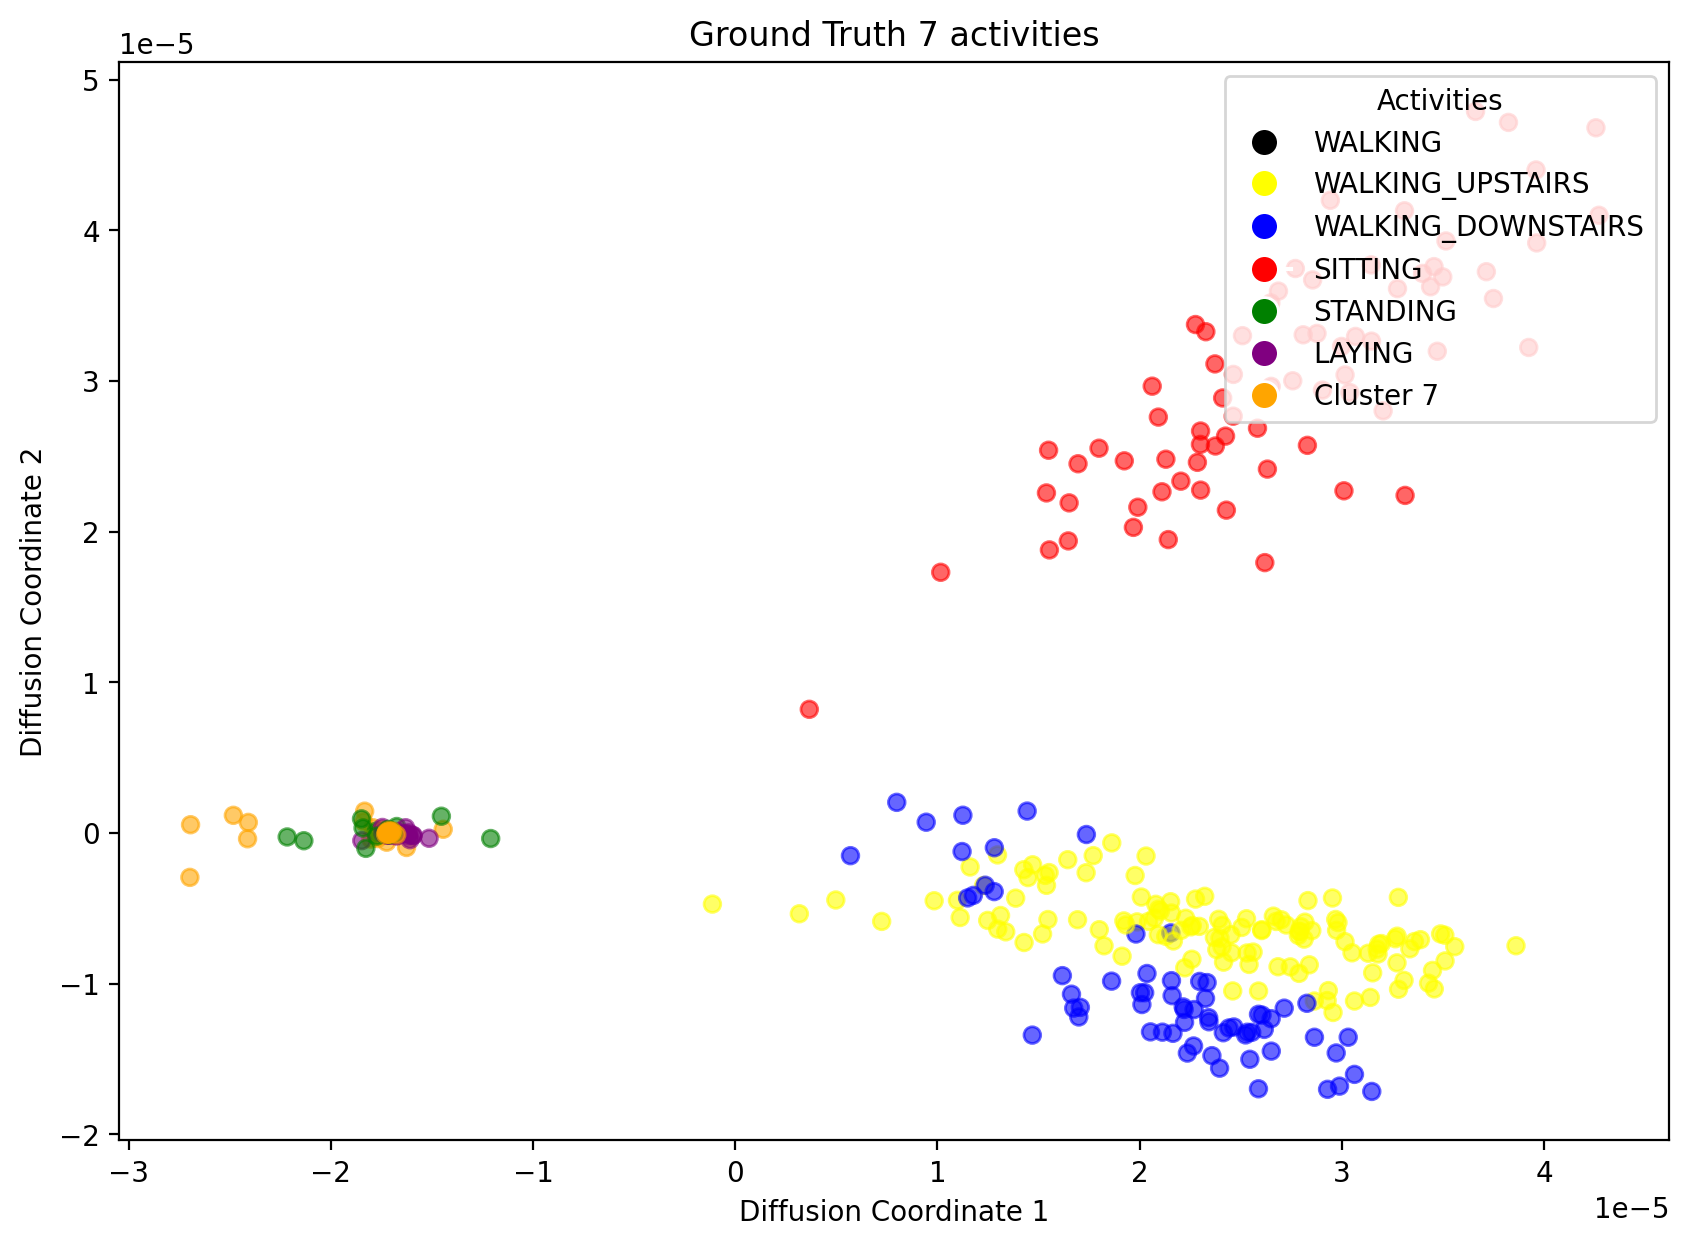

In [44]:
activity_labels = {  
    1: "WALKING",  
    2: "WALKING_UPSTAIRS",  
    3: "WALKING_DOWNSTAIRS",  
    4: "SITTING",  
    5: "STANDING",  
    6: "LAYING"  
}

cluster_colors = ["black", "yellow", "blue", "red", "green", "purple", "orange"]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(diffusion_coords[:, 0], diffusion_coords[:, 1], 
                       c=[cluster_colors[label] for label in y_train_need], alpha=0.6)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10) 
           for i in range(k_given)]
plt.legend(handles, [activity_labels.get(i + 1, f"Cluster {i + 1}") for i in range(k_given)], 
           title="Activities", loc="upper right")

plt.xlabel("Diffusion Coordinate 1")
plt.ylabel("Diffusion Coordinate 2")
plt.title(f"Ground Truth 7 activities")
plt.show()